In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("../data/clean_data.csv")
cluster_df = pd.read_csv("../data/clustered_time_patterns.csv")

In [18]:
df.columns

Index(['Timestamp (UTC)', 'Hour', 'Delay (s)', 'Cold_Start', 'timestamp',
       'hour', 'dayofweek', 'is_weekend', 'prev_delay_1', 'prev_cold_1',
       'prev_delay_2', 'prev_cold_2', 'prev_delay_3', 'prev_cold_3',
       'rolling_avg_delay', 'rolling_cold_rate', 'anomaly_flag',
       'last_cold_time', 'time_since_last_cold', 'cold_start_prob_est',
       'bucket_Night', 'bucket_Morning', 'bucket_Afternoon', 'bucket_Evening',
       'cluster', 'cold_start_ratio', 'total_invocations', 'cold_start_proba',
       'predicted_delay', 'prewarm', 'cold_start_cost', 'prewarm_cost',
       'net_savings'],
      dtype='object')

In [3]:
if 'time_bucket' in df.columns and 'time_bucket' in cluster_df.columns:
    df = df.merge(cluster_df[['hour', 'dayofweek', 'time_bucket', 'cluster', 'cold_start_ratio', 'total_invocations']],
                  on=['hour', 'dayofweek', 'time_bucket'], how='left')
else:
    df = df.merge(cluster_df[['hour', 'dayofweek', 'cluster', 'cold_start_ratio', 'total_invocations']],
                  on=['hour', 'dayofweek'], how='left')

In [4]:
clf = joblib.load("../models/cold_start_classifier.pkl")
reg = joblib.load("../models/delay_predictor.pkl")

In [5]:
print("\n Running Inference")
clf_features = ['hour', 'dayofweek', 'is_weekend', 'cluster',
                'prev_delay_1', 'prev_delay_2', 'prev_delay_3',
                'prev_cold_1', 'prev_cold_2', 'prev_cold_3']


reg_features = ['cold_start_ratio', 'total_invocations', 'cluster', 'anomaly_flag', 'cold_start_prob_est']


 Running Inference


In [6]:
missing_clf = [f for f in clf_features if f not in df.columns]
missing_reg = [f for f in reg_features if f not in df.columns]
if missing_clf:
    raise ValueError(f"Missing classification features: {missing_clf}")
if missing_reg:
    raise ValueError(f"Missing regression features: {missing_reg}")

In [7]:
df['cold_start_proba'] = clf.predict_proba(df[clf_features])[:, 1]

In [8]:
if 'cold_start_prob_est' not in df.columns:
    df['cold_start_prob_est'] = df['cold_start_proba']

In [9]:
df['predicted_delay'] = reg.predict(df[reg_features])


In [10]:
def smart_prewarm(prob, delay, prob_thresh=0.6, delay_thresh=400):
    return int(prob > prob_thresh or delay > delay_thresh)
df['prewarm'] = df.apply(lambda row: smart_prewarm(row['cold_start_proba'], row['predicted_delay']), axis=1)

In [11]:
cold_start_penalty = 0.005  # $/second of cold start delay
prewarm_cost = 0.002        # $ per prewarm action
df['cold_start_cost'] = df['Cold_Start'] * df['Delay (s)'] * cold_start_penalty
df['prewarm_cost'] = df['prewarm'] * prewarm_cost
df['net_savings'] = df['cold_start_cost'] - df['prewarm_cost']

In [12]:
total = len(df)
actual_cold_starts = df['Cold_Start'].sum()
predicted_cold_starts = (df['cold_start_proba'] > 0.6).sum()
prewarm_actions = df['prewarm'].sum()
total_cold_cost = df['cold_start_cost'].sum()
total_prewarm_cost = df['prewarm_cost'].sum()
total_savings = df['net_savings'].sum()

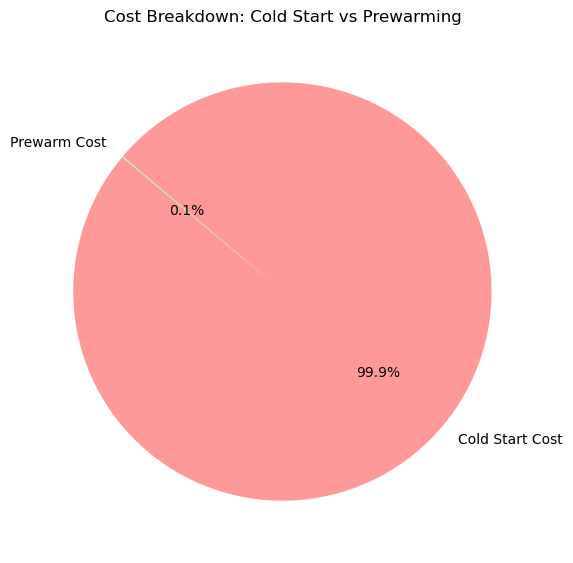

In [13]:
costs = [total_cold_cost, total_prewarm_cost]
labels = ['Cold Start Cost', 'Prewarm Cost']
colors = ['#FF9999', '#99FF99']

plt.figure(figsize=(6, 6))
plt.pie(costs, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Cost Breakdown: Cold Start vs Prewarming')
plt.tight_layout()
plt.savefig("fig_cost_breakdown.png")
plt.show()


C:\Users\tanzi\AppData\Local\Temp\ipykernel_30184\1322687068.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='prewarm', y='Delay (s)', palette='Set2')


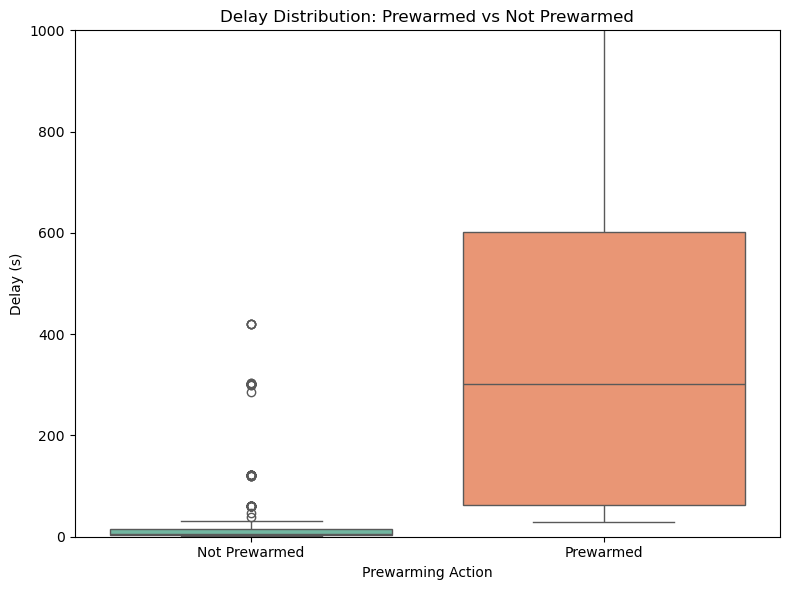

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='prewarm', y='Delay (s)', palette='Set2')
plt.xticks([0, 1], ['Not Prewarmed', 'Prewarmed'])
plt.ylim(0, 1000)  # or 0–1500 depending on your data spread
plt.title('Delay Distribution: Prewarmed vs Not Prewarmed')
plt.xlabel('Prewarming Action')
plt.ylabel('Delay (s)')
plt.tight_layout()
plt.savefig("fig6_prewarm_vs_no_prewarm_zoomed.png")
plt.show()




In [15]:
print("=== Summary ===")
print(f"Total Requests: {total}")
print(f"Actual Cold Starts: {actual_cold_starts}")
print(f"Predicted Cold Starts (>60% prob): {predicted_cold_starts}")
print(f"Prewarming Actions Taken: {prewarm_actions}")
print(f"Total Cold Start Cost: ${total_cold_cost:.2f}")
print(f"Total Prewarming Cost: ${total_prewarm_cost:.2f}")
print(f"Net Cost Savings: ${total_savings:.2f}")

=== Summary ===
Total Requests: 10627
Actual Cold Starts: 315
Predicted Cold Starts (>60% prob): 511
Prewarming Actions Taken: 527
Total Cold Start Cost: $1370.13
Total Prewarming Cost: $1.05
Net Cost Savings: $1369.08
